In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Load and Process the Data

In [2]:
data = np.loadtxt('data/data.csv', delimiter=',')

The last 13 rows of the data represent my output

In [3]:
X = np.transpose(data[:-13,:])
Y = np.transpose(data[-13:,:])

Every channel has a background of around ~150. We don't want to factor that in. Output should always be positive, so these have been scaled in the range $\left[0,1\right]$.

In [4]:
X.shape

(140, 11725)

In [5]:
inscale = MinMaxScaler()
outscale = MinMaxScaler()

In [6]:
xs = inscale.fit_transform(X)
ys = outscale.fit_transform(Y)

Split the data into **train**, **test**, and **val**idation segments.

The data are in blocks of 20 measurements for each sample. Since the samples should be independent of each other, we can randomly select from each of the 7 samples. I have elected for a 70/15/15 train/test/validate split. 

*Should my output layer be linear (to try and estimate the amount of material in a spectrum) or LogSig/Softmax (material present or not)*

*Can't use hardlim with backpropagation because it is not differentiable*

*Softmax--multiclassification problem*

In [26]:
# Choose 6 random numbers from 1-20.
c = np.random.choice(range(20), 6, replace=False)

# Make these the indexes we will use for our test/validation
while c.shape[0] <= (xs.shape[0] - 6) * 0.3:
    c = np.concatenate((c, c[-6:]+20))

In [27]:
xs_test = np.array([xs[i, :] for i in c[::2]])
ys_test = np.array([ys[i, :] for i in c[::2]])
xs_val = np.array([xs[i, :] for i in c[1::2]])
ys_val = np.array([ys[i, :] for i in c[1::2]])
xs_train = np.delete(xs, c, 0)
ys_train = np.delete(ys, c, 0)
print(xs_test.shape)
print(ys_test.shape)
print(xs_val.shape)
print(ys_val.shape)
print(xs_train.shape)
print(ys_train.shape)

(21, 11725)
(21, 13)
(21, 11725)
(21, 13)
(98, 11725)
(98, 13)


We now have 98 training records, 21 testing records, and 21 validation records. Each record is a vector of 11725 input values and 13 output values.

# Goals #
There are three goals for this project. In increasing order of difficulty (and desirability), they are:

1. Classify which of the 7 candidate materials was present in the sample (with a confidence measurement)
2. Identify the presence or absence of one or more of the constituent materials in a sample
3. Identify the amount of each material that is present in a sample

# Goal \#1 #

The goal of this is to determine which of seven candidates a new sample matches. It should produce a classification and (ideally) a confidence prediction. For this, a radial basis function network was chosen. Since each spectra has 11725 (!) values, that is the number of input neurons. Since there are 7 potential candidates, that is the number of neurons in the hidden layer, and the number of neurons in the output layer.

## Attempt \#1 ##
Use 7 hidden neurons in the hidden layer; set them based on an average of all of the spectra of each sample.

For each sample we have 14 spectra. Reshape the input data into bins of 7 x 14 x 11725, then average along each sample to create representative spectra for the hidden layer.

In [28]:
tmp = np.reshape(xs_train, (7,14,11725))
avg_spectra = np.mean(tmp, 1)

Define a `tf.constant` for each sample array in avg_spectra

In [42]:
samples = np.array([tf.constant(avg_spectra[i,:], name="spectrum{}".format(i)) for i in range(avg_spectra.shape[0])])

In [46]:
x = tf.placeholder(tf.float32, [None, 11725])

Set up our weights

In [47]:
W = tf.Variable(tf.zeros([11725, 7]))
b = tf.Variable(tf.zeros([7]))

In [48]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

In [73]:
def rbf(x, p, beta=1.):
    return np.sum(np.exp(- beta * (x - p) ** 2))

In [74]:
rbf(avg_spectra[0], xs_train[0])

11531.119887123961

In [75]:
rbf(avg_spectra[0, :], xs_train[-1, :])

10763.397031788465

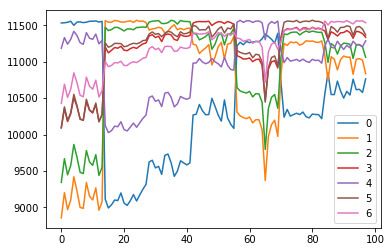

In [76]:
for i in range(7):
    plt.plot([rbf(avg_spectra[i], xs_train[j,:]) for j in range(xs_train.shape[0])], label=i)
plt.legend(loc='lower right')
plt.show()

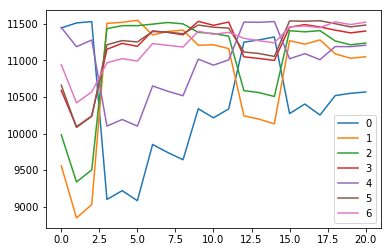

In [77]:
for i in range(7):
    plt.plot([rbf(avg_spectra[i], xs_test[j,:]) for j in range(xs_test.shape[0])], label=i)
plt.legend(loc='lower right')
plt.show()

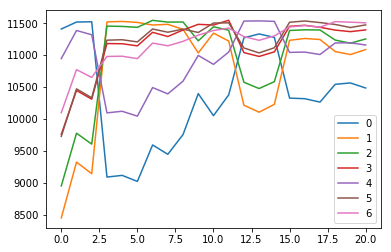

In [78]:
for i in range(7):
    plt.plot([rbf(avg_spectra[i], xs_val[j,:]) for j in range(xs_val.shape[0])], label=i)
plt.legend(loc='lower right')
plt.show()

Let's just try to get our math first

In [81]:
phi0 = tf.constant(avg_spectra[0], dtype=tf.float32, name='sample0')
beta = tf.constant(1., dtype=tf.float32, name='beta')
x = tf.placeholder(tf.float32, [None, 11725])
a = tf.subtract(phi0, x)
b = tf.square(a)
c = tf.multiply(-1., beta)
d = tf.multiply(beta, b)
e = tf.exp(d)
f = tf.reduce_sum(e)
print(f)

TypeError: Input 'y' of 'Mul' Op has type float64 that does not match type float32 of argument 'x'.